In [2]:
import pandas as pd
import numpy as np
from numpy import mean, std, median
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,  train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, recall_score,r2_score, accuracy_score, cohen_kappa_score, classification_report, confusion_matrix, precision_score,f1_score 
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, KFold, StratifiedKFold 
from imblearn.pipeline import Pipeline 
from imblearn.pipeline import make_pipeline as imbpipeline
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
#Random seed used in R was 7
random_seed=7

In [4]:
#read input data
#data=pd.read_csv('GS_majority_vote.csv') #all 986 synsets
data=pd.read_csv('GS_All_Agreed.csv') #839 synsets where all annotators agree

In [5]:
d_tools=pd.DataFrame(data.loc[data['domain_x']=='tool'])
d_fruit=pd.DataFrame(data.loc[data['domain_x']=='fruit'])
d_music=pd.DataFrame(data.loc[data['domain_x']=='music'])
d_furn=pd.DataFrame(data.loc[data['domain_x']=='furn'])
d_garm=pd.DataFrame(data.loc[data['domain_x']=='garm'])

In [6]:
three=data[data['domain_x']!='furn']

In [7]:
fmt=three[three['domain_x']!='garm']

In [8]:
#list(data)

In [10]:
#set features and target variable
features=[ 
      'ngrams_last_mean',
    'minwordlength_x',
 'nroflemmas_x',
    'polyscore_max_x',
    'nrpartrels_normalised_x',
    'nrhypos_x',
    'glosslength_normalised_x',
    'depthfromtopsynset_normalised_x',
    'nrdirhypers_x',
    'CHILDES_Sum_Rel',
    'BNC_sum'
 ]
target=['vote_x']

In [11]:
X=np.array(data[features])
y= np.array(data[target] )
#X=np.array(fmt[features])
#y= np.array(fmt[target] )
#X = np.array(d_music[features])
#y = np.array(d_music[target])
#X=np.array(d_tools[features])
#y=np.array(d_tools[target])
#X=np.array(d_fruit[features])
#y= np.array(d_fruit[target])
#X=np.array(d_furn[features])
#y= np.array(d_furn[target])
#X=np.array(d_garm[features])
#y= np.array(d_garm[target])

In [12]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  54  55
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  77  78  79  80  81  82  83  84  85  86  87  88  89  90  92  93  94
  95  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 121 122 123 124 125 126 127 128 129 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 158 159 161 163 164 165 166 167 168 169 170 171 172
 174 175 176 177 178 179 180 181 184 185 188 189 190 191 192 193 194 195
 196 197 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 225 226 227 228 229 230 231 232 233
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 253 254
 255 256 257 258 259 261 262 263 264 265 266

In [13]:
#run SMOTE algorithm to deal with class imbalances - make basic class same amount as non-basic
sm = SMOTE(random_state=random_seed, k_neighbors=2)
X_train, y_train = sm.fit_resample(X_train, y_train)
print ('Shape of oversampled data: {}'.format(X_train.shape))
print ('Shape of Y: {}'.format(y_train.shape))

Shape of oversampled data: (1196, 11)
Shape of Y: (1196,)


In [14]:
#define model and fit oversampled training sets
rf = RandomForestClassifier(random_state=random_seed, max_features='sqrt', n_estimators=500, oob_score=True, criterion='gini', bootstrap=True).fit(X_train, y_train.ravel())

In [15]:
kappa_scorer=make_scorer(cohen_kappa_score)

In [16]:
pipeline=imbpipeline(sm, rf)

In [17]:
kappa=[]

In [18]:
kappa_scores=cross_val_score(pipeline, X, y.ravel(), scoring=kappa_scorer, cv=skf)
kappa.append(kappa_scores)
print(kappa_scores)
print("Mean Kappa score: %0.3f (+/- %0.3f)" % (kappa_scores.mean(), kappa_scores.std()*2))

[0.56578947 0.58527828 0.66068223 0.77875329 0.60309278 0.64678899
 0.66129032 0.82673267 0.68811881 0.75700544]
Mean Kappa score: 0.677 (+/- 0.164)


In [19]:
median=np.median(kappa)
median

0.6609862743962472

In [20]:
df=pd.DataFrame()
df['ngrams, BNC and CHILDES']=kappa_scores
quart=df['ngrams, BNC and CHILDES'].describe()
df1=pd.DataFrame(quart).transpose()

In [21]:
df1

,count,mean,std,min,25%,50%,75%,max
"ngrams, BNC and CHILDES",10.0,0.677353,0.086259,0.565789,0.614017,0.660986,0.739784,0.826733


In [22]:
y_pred = pipeline.predict(X_test)

In [23]:
#predict test set from cross val splits
cr=(classification_report(y_test,y_pred, output_dict=True))
report=pd.DataFrame(cr).transpose()
report
cr=(classification_report(y_test,y_pred, output_dict=True))
ck=(cohen_kappa_score(y_test, y_pred))
ba=(balanced_accuracy_score(y_test, y_pred))
report=pd.DataFrame(cr).transpose()
report['Cohen Kappa']=ck
report['Balanced Accuracy']=ba

In [24]:
report

,precision,recall,f1-score,support,Cohen Kappa,Balanced Accuracy
b,0.750000,0.882353,0.810811,17.000000,0.757005,0.903298
nb,0.968254,0.924242,0.945736,66.000000,0.757005,0.903298
accuracy,0.915663,0.915663,0.915663,0.915663,0.757005,0.903298
macro avg,0.859127,0.903298,0.878274,83.000000,0.757005,0.903298
weighted avg,0.923551,0.915663,0.918101,83.000000,0.757005,0.903298


Feature: 0, Score: 0.08237
Feature: 1, Score: 0.07793
Feature: 2, Score: 0.04516
Feature: 3, Score: 0.06445
Feature: 4, Score: 0.11804
Feature: 5, Score: 0.05926
Feature: 6, Score: 0.10235
Feature: 7, Score: 0.31125
Feature: 8, Score: 0.01138
Feature: 9, Score: 0.03637
Feature: 10, Score: 0.09144


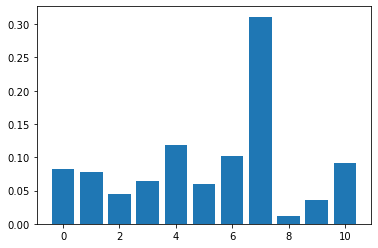

In [25]:
# get feature importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig1=plt.figure()
a=plt.bar([x for x in range(len(importance))], importance)
#plt.savefig('ck/feature_importance_global.png')
plt.show()

In [26]:
imp=[]
for i,v in enumerate(importance):
    imp.append(v)

In [27]:
df4=pd.DataFrame(imp)
df4['Features']=features
df4=df4.rename(columns={0:'Importance'})

In [28]:
df5=df4[['Features', 'Importance']].sort_values('Importance',ascending=False)

In [29]:
df5=df5.rename(columns={'index':'Rank'})

In [30]:
df5

,Features,Importance
7,depthfromtopsynset_normalised_x,0.311245
4,nrpartrels_normalised_x,0.118038
6,glosslength_normalised_x,0.102350
10,BNC_sum,0.091438
0,ngrams_last_mean,0.082372
1,minwordlength_x,0.077932
3,polyscore_max_x,0.064451
5,nrhypos_x,0.059262
2,nroflemmas_x,0.045155
9,CHILDES_Sum_Rel,0.036373


In [29]:
#df1.to_csv('results/FQ/combined/cv_ck_11.csv')

In [30]:
#report.to_csv('results/FQ/combined/CR_11.csv')

In [31]:
#df5.to_csv('results/FQ/combined/FI_11.csv')

In [31]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 7, 'verbose': 0, 'warm_start': False}


In [32]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [33]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = skf, verbose=2, random_state=random_seed, n_jobs = -1)

In [34]:
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


C:\Users\niamh\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.9372549  0.9272619  0.94310924        nan        nan
 0.94395658        nan 0.94144958        nan 0.93642157        nan
        nan        nan 0.93473389        nan 0.9272619         nan
 0.94228291 0.94312325        nan 0.94144258        nan 0.93473389
 0.94228291        nan 0.93306723        nan 0.9272619         nan
 0.94646359        nan 0.94060924        nan        nan        nan
 0.94060924        nan        nan 0.92557423 0.93473389 0.94394958
        nan 0.9297619  0.94395658 0.94395658        nan        nan
 0.94395658 0.93310924]
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
                   estimator=RandomForestClassifier(max_features='sqrt',
                                                    n_estimators=500,
                                                    oob_score=True,
                                                    random_state=7),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
             

In [35]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}